# Waveform Signal Simulation

Here we provide a simulation of the signal after it has passed through the lock in.
We model each component individually to obtain a qualitative description of the basic features of the signal.

---

## Component Modelling
Let's define a transfer function for each of the circuit components. Let's get a phase angle signal, relative to the axis of the first polarizer.

$$\phi(t) = \Phi cos(\omega t)$$

Where $\omega$ is the angular frequency of the signal. We se that signal's phase to be zero, so we are going to measure every phase with respect to that. The goal is to measure the amplitude of that signal $\Phi$, which is the verdet angle at that field. 

### Polariser and sensor
After it passes the second polariser and get's detected by the sensor, the voltage signal is going to be of the form:

$$V_s = A_s\, I\, \cos^2\phi(t) + W(t)$$

Note that here $I$ is not the current, rather the light intensity incident on the second polariser. $V_s$ is the sensor voltage with respect to the common ground, and $A_s$ is some conversion factor from intensity to voltage specific to the sensor. We assume that we are operating in the linear mode of the sensor. Finally, W(t) is some gaussian sampled white noise introduced there just for variety.

### Preamplifier
The preamplifier can be simplistically modelled as a constant ($G_p$ the gain of the preamp) multiplying the input signal. This is to first order, at reasonable frequencies. See instrunment specificication for these.

$$V_p(t) = G_p V_s(t)$$


### Lock in Detector
The lock-in's function is a bit more complicated to modell. An ideal lock in would multiply the reference signal given by $V_{ref}$ below, with a single frequency from the spectrum of the input signal (in this case V_s).

$$V_{ref} = cos(\omega_r t + \theta)$$

Here $\omega_r$ is the frequency of the reference signal, and $\theta$ is its relative phase with $phi(t)$. We set the reference signal amplitude to 1, but this is just to simplify the algebra. We will bring it back later.

Now what is the signal after the lock in? 

> Let's first examine the **ideal case**. In the ideal case to obtain one frequency, we would just get the fourier coefficients for that frequency and then restransform a delta around it. That would be:
> 
> $$ C_{\pm \omega_r} = \int_{\mathbb{R}} V_p(t)\, e^{\mp i \omega_r t}\, dt$$
> 
> So we have that the amplitude of the signal is the amplitude of the cosine component with the amplitude the sin component. Hence the final signal will have amplitude:
> 
> $$A_{lock}=\sqrt{\frac{C_{\omega_r}^2 + C_{-\omega_r}^2}{2}}$$
> 
> and phase:
> 
> $$\theta_{lock} = \tan^{-1}\frac{C_{\omega_r} - C_{-\omega_r}}{C_{\omega_r} +C_{-\omega_r} }$$
> 
> Hence the output of the ideal lock in detector would be:
> 
> $$ V_{lock} = A_{lock}\cos(\omega_r t + \theta_{lock})\, V_{ref}(t) $$

However for the non-ideal case, it is slightly harder to single out a particular frequency. Hence to modell the effect of an imperfect lock-in amplifier, instead of multiplying with a delta function to obtain the signal back, we will multiply with a gaussian distribution when taking the inverse fourier transform. This is done as follows:

$$V_{lock} = V_{ref}(t)\, \frac{1}{2\pi} \iint_{\mathbb{R}^2} V_p(t) \, e^{i \omega t} dt\, G_{\sigma}(\omega - \omega_r)\, e^{-i \omega t}d\omega $$

This may look a bit complicated, but it really isn't. We are almost rewriting Fourier's Identity (the inverse fourier transform of the transform of a function is the same function), however before we take the inverse fourier transform back to the time domain, we cut a range of frequencies centered at $\omega_r$ with some standard deviation $\sigma$. Finally we multiply by the reference signal and this is it!

Why did we bother to do all of this? The lock in is imperfect, if we want to properly evaluate our simulation then we will have to take this effect into account. 

---

## Implementation

What follows is the implementation of the above logic, in order to simulate the signal we obtained from the lock in amplifier.


In [1]:
# Load necesary libraries
import numpy as np
import matplotlib.pyplot as plt
import wfsim as wf
from tqdm import tqdm
import numpy.fft as fft

# %matplotlib notebook


(2.0, 3.0)

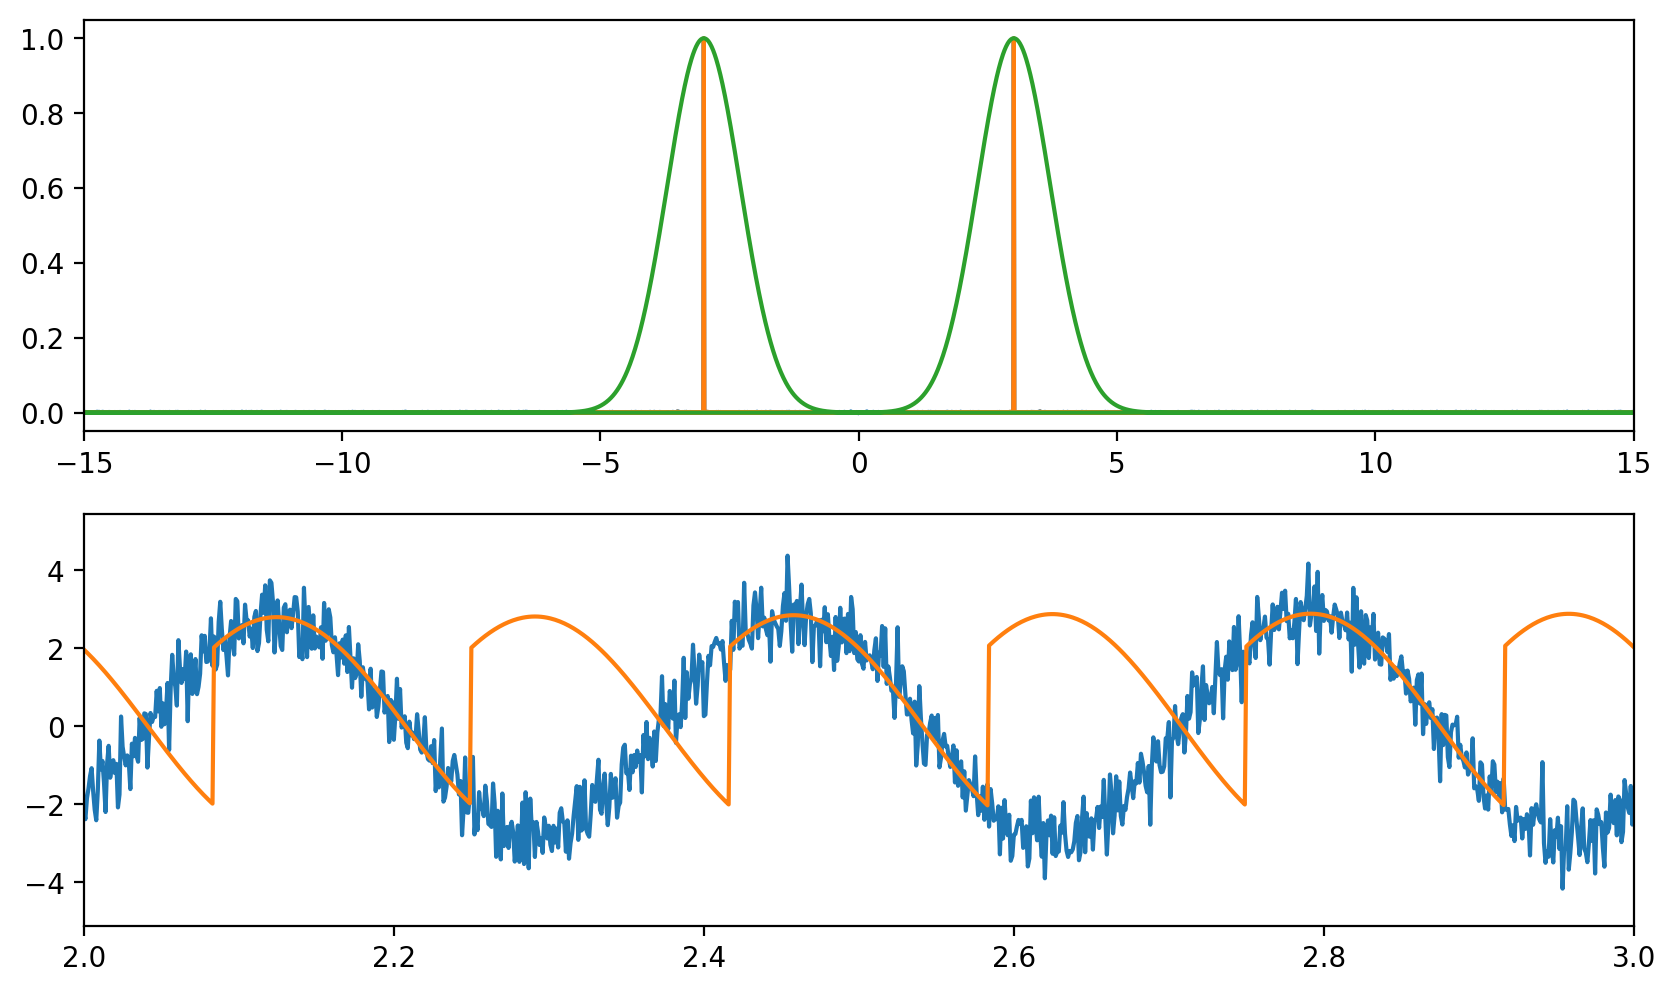

In [20]:
# Relevant Constants
params = {
    "Npts"            : 100000,                # Number of sampling points
    "t_min"           : 0,                     # Minimum Time in s
    "t_max"           : 100,                   # Maximum Time in s
    "ANG_amplitude"   : 0.1,                   # Amplitude of roration angle
    "ANG_frequency"   : 3,                     # Frequency of rotation angle
    "ANG_phase"       : 0,                     # Phase of rotation angle
    "ANG_offset"      : np.pi*45/180,          # Offset of rotation angle
    "BG_amplitude"    : 2,                  # Amplitude of Background signal
    "BG_frequency"    : 3,                     # Frequency of Background signal
    "BG_phase"        : np.pi/7,               # Phase of Background signal
    "polariser_angle" : 0,                     # Polariser Angle
    "sig_amplitude"   : 20,                     # Conversion from angle to signal amplitude
    "noise_amplitude" : 0.5,                  # Amplitude of white noise
    "noise_min_freq"  : 0,                     # Minimum Frequency for noise
    "noise_max_freq"  : 0,                     # Maximum Frequency for noise
    "Noise_fs"        : 1,                     # Noise Sample Rate
    "preamp_gain"     : 1,                     # Gain of preamplifier
    "lpf_fc"          : 1,                     # Low pass filter cuttoff frequency in Hz
    "ref_phase"       : np.pi*180/180,         # Phase of reference signal
    "lock_in_gain"    : 1,                     # Lock in gain
    "lock_in_std"     : 1,                     # Lock in standard deviation
    "time_constant"   : 1,                     # Low pass filter amplifier time constant
}

time,ang,ref,sig_raw,sig_pre,sig_loc,sig_lpa = wf.get_signal(params)

sig_pre -= np.mean(sig_pre)
F = fft.fft(sig_pre)
fs = len(time)/(max(time)-min(time))
freq = fft.fftfreq(len(F),d=1/fs)
# F, freq = wf.lock_in(sig_pre,ref,time,params["ANG_frequency"],sigma=1,ref_shifted=None,gain=1)

fig = plt.figure(figsize=(10,6),dpi=200)
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ss = params['lock_in_std']
G = (np.exp(-(freq-params["ANG_frequency"])**2/ss**2)+np.exp(-(freq+params["ANG_frequency"])**2/ss**2))
# G = 1-np.exp(-(freq)**2/ss**2)
FF = F*G

ax.plot(freq,abs(F)/max(abs(F)))
# ax.plot(freq,abs(F.real)/max(abs(F.real)))
# ax.plot(freq,abs(F.imag)/max(abs(F.imag)))
ax.plot(freq,abs(FF)/max(abs(FF)))
ax.plot(freq,G)
ax.set_xlim(-15,15)

FFF = fft.ifft(FF)
FFF = FFF.real + FFF.imag
ax2.plot(time,sig_pre)
# ax2.plot(time,FFF)
# ax2.plot(time,FFF*np.sign(ref))
ax2.plot(time,sig_loc)
# ax2.plot(time,ref)
ax2.set_xlim(2,3)

100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


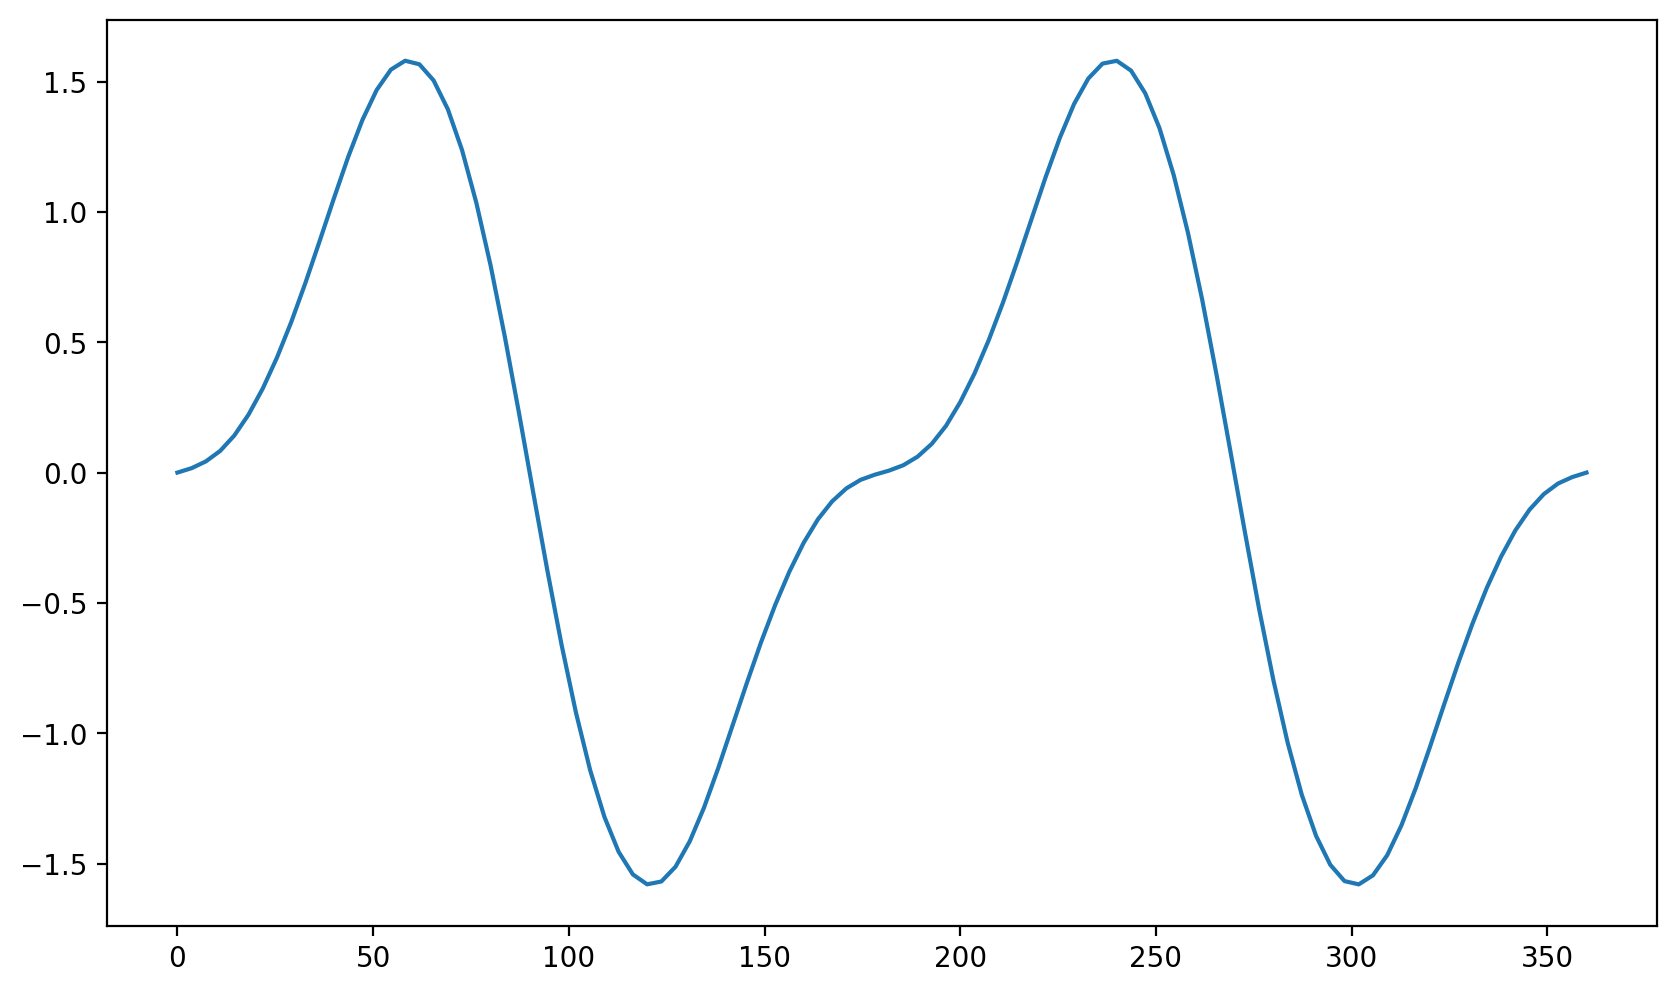

In [18]:
angle = np.linspace(0,360,100)
V=[]
for a in tqdm(angle):
    params["ANG_offset"] = np.pi*a/180
    time,ang,ref,sig_raw,sig_pre,sig_loc,sig_lpa = wf.get_signal(params)
    
    V.append(np.mean(sig_loc))
    
fig2 = plt.figure(figsize=(10,6),dpi=200)
ax3 = fig2.add_subplot(111)
ax3.plot(angle,V)

In [19]:
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

# band_limited_noise(0,30,samples=1000,samplerate=1)

(1.0, 3.0)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


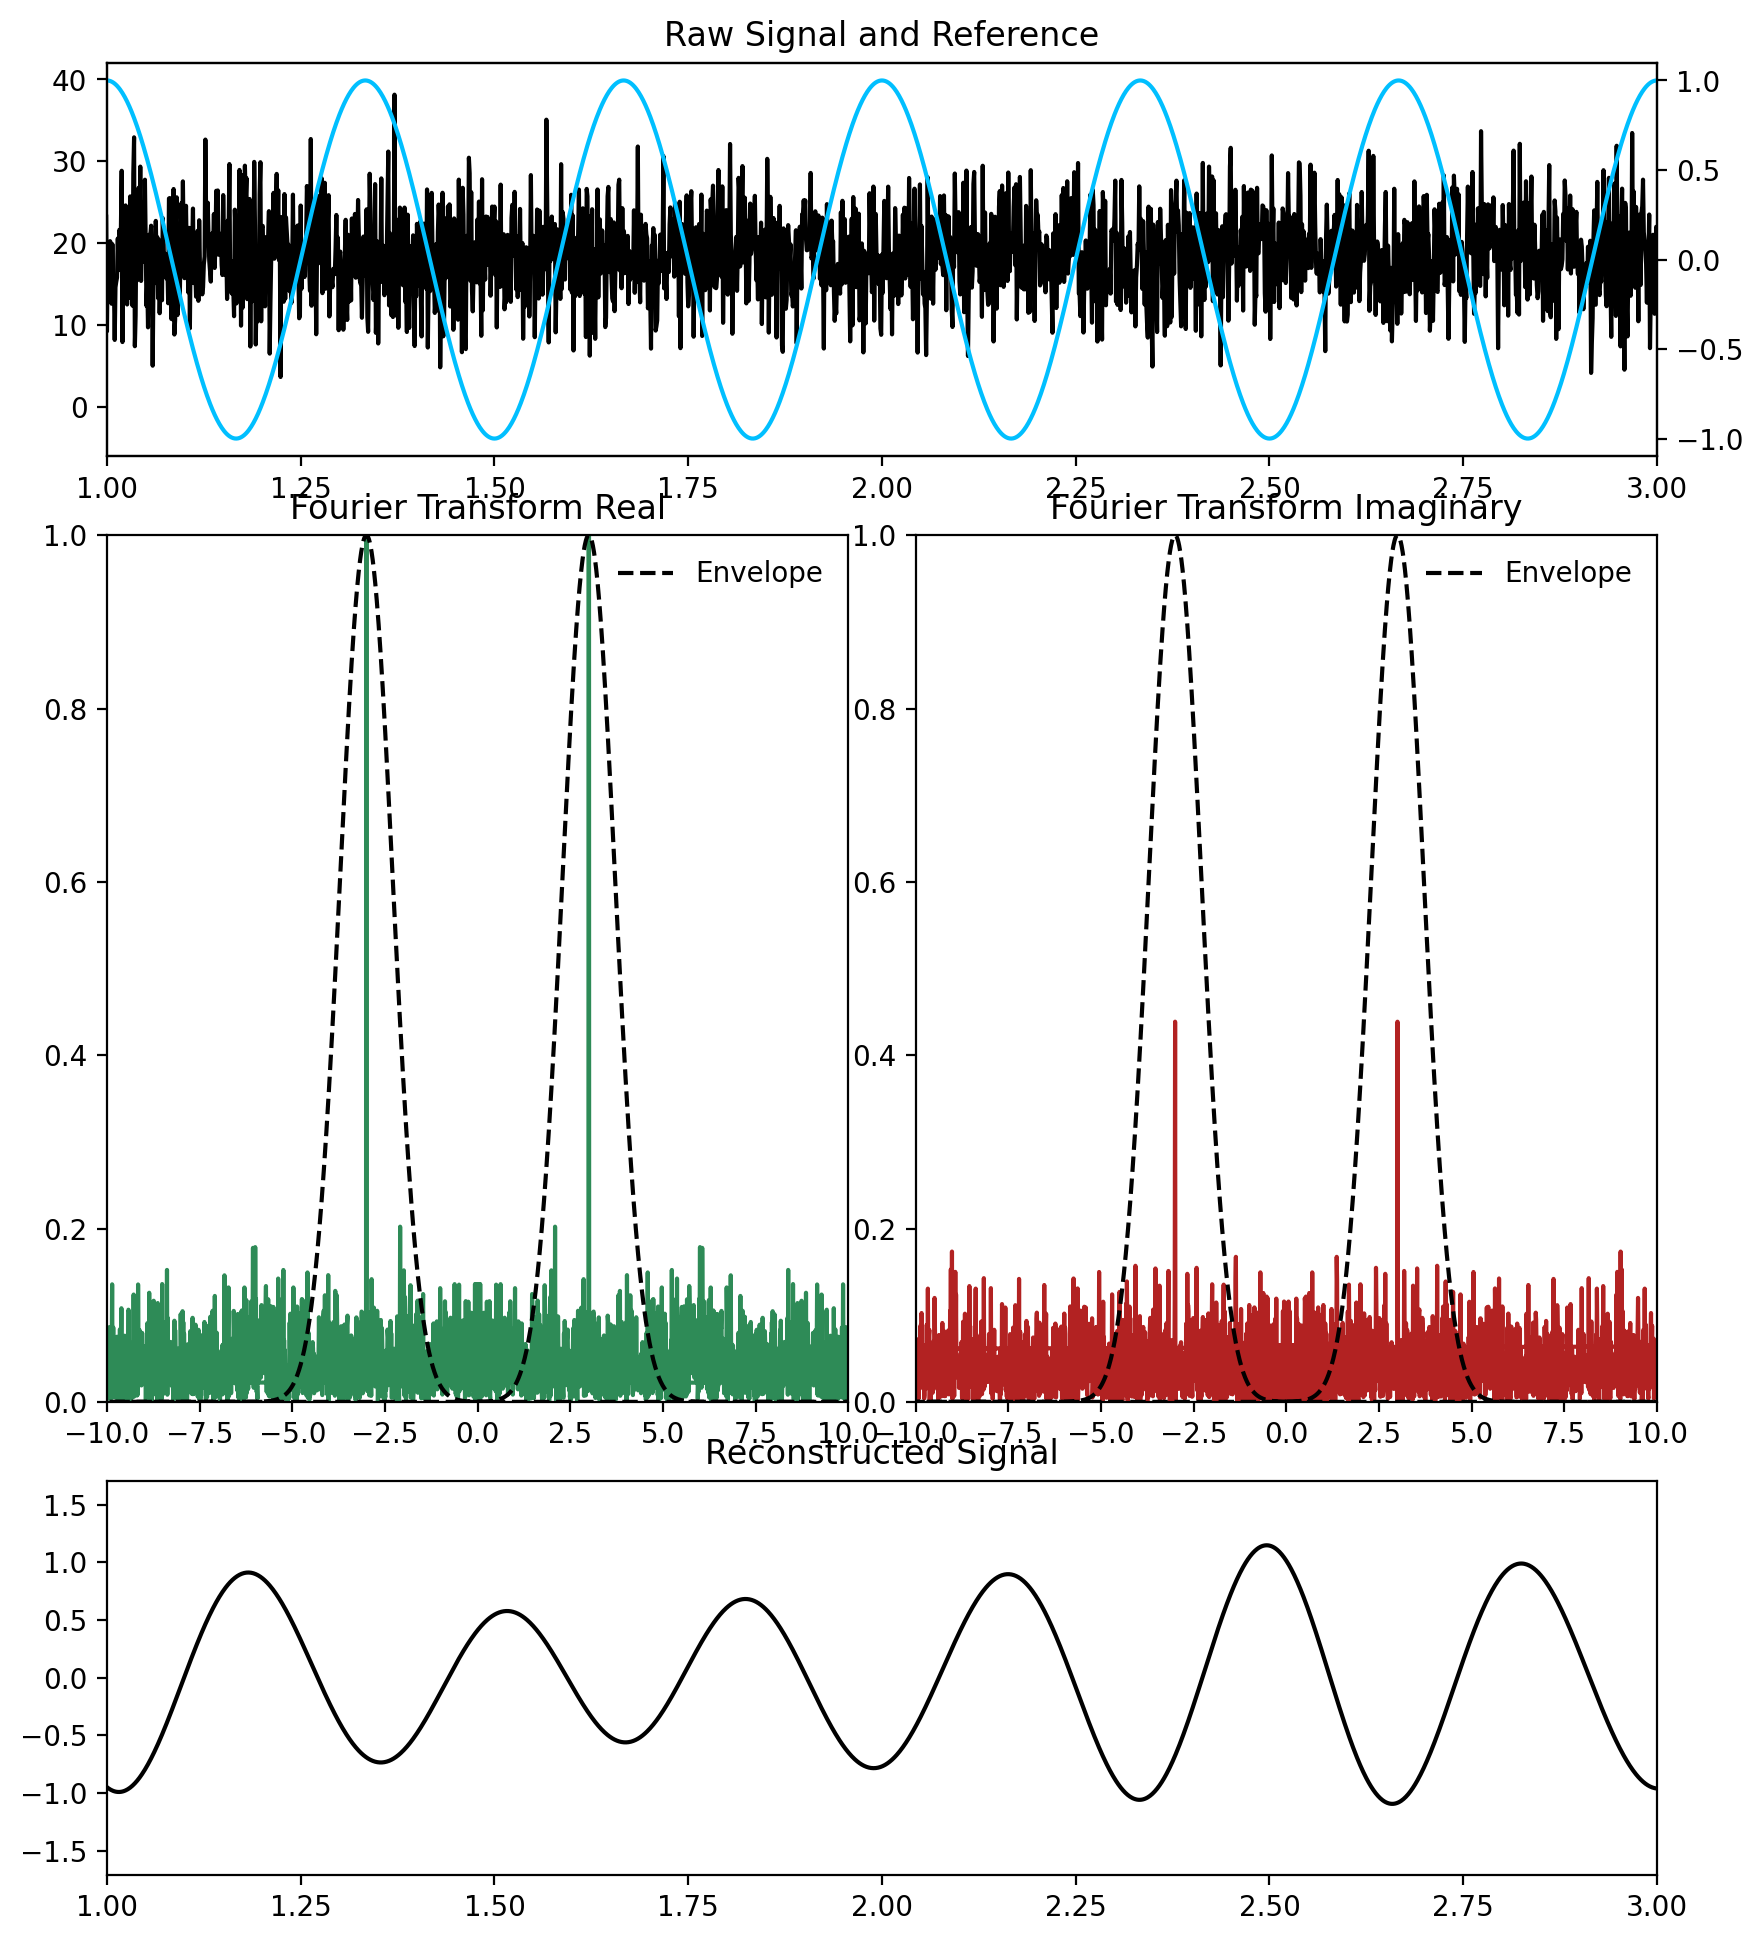

In [5]:
# Relevant Constants
params = {
    "Npts"            : 100000,                # Number of sampling points
    "t_min"           : 0,                     # Minimum Time in s
    "t_max"           : 100,                   # Maximum Time in s
    "ANG_amplitude"   : 0.1,                   # Amplitude of roration angle
    "ANG_frequency"   : 3,                     # Frequency of rotation angle
    "ANG_phase"       : np.pi*10/180,                    # Phase of rotation angle
    "ANG_offset"      : np.pi*15/180,          # Offset of rotation angle
    "BG_amplitude"    : 0,                  # Amplitude of Background signal
    "BG_frequency"    : 3,                     # Frequency of Background signal
    "BG_phase"        : np.pi/7,               # Phase of Background signal
    "polariser_angle" : 0,                     # Polariser Angle
    "sig_amplitude"   : 20,                     # Conversion from angle to signal amplitude
    "noise_amplitude" : 5,                  # Amplitude of white noise
    "noise_min_freq"  : 0,                     # Minimum Frequency for noise
    "noise_max_freq"  : 0,                     # Maximum Frequency for noise
    "Noise_fs"        : 1,                     # Noise Sample Rate
    "preamp_gain"     : 1,                     # Gain of preamplifier
    "lpf_fc"          : 1,                     # Low pass filter cuttoff frequency in Hz
    "ref_phase"       : np.pi*0/180,         # Phase of reference signal
    "lock_in_gain"    : 1,                     # Lock in gain
    "lock_in_std"     : 1,                     # Lock in standard deviation
    "time_constant"   : 1,                     # Low pass filter amplifier time constant
}

time,ang,ref,sig_raw,sig_pre,sig_loc,sig_lpa = wf.get_signal(params)

sig_pre -= np.mean(sig_pre)
F = fft.fft(sig_pre)
fs = len(time)/(max(time)-min(time))
freq = fft.fftfreq(len(F),d=1/fs)
# F, freq = wf.lock_in(sig_pre,ref,time,params["ANG_frequency"],sigma=1,ref_shifted=None,gain=1)

ss = params['lock_in_std']
G = (np.exp(-(freq-params["ANG_frequency"])**2/ss**2)+np.exp(-(freq+params["ANG_frequency"])**2/ss**2))
# G = 1-np.exp(-(freq)**2/ss**2)
FF = F*G


fig = plt.figure(figsize=(10,12),dpi=200,constrained_layout=True)
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1:3,:2])
ax3 = fig.add_subplot(gs[1:3,2:])
ax4 = fig.add_subplot(gs[3,:])

ax1.set_title('Raw Signal and Reference')
ax1.plot(time,sig_raw,c='k')
ax11 = ax1.twinx()
ax11.plot(time,ref,c='deepskyblue')
ax1.set_xlim(1,3)

ax2.set_title('Fourier Transform Real')
ax2.plot(freq,abs(F.real)/20000,c='seagreen')
ax2.plot(freq,G,c='k',ls='--',label='Envelope')
ax2.set_xlim(-10,10)
ax2.set_ylim(0,1)
ax2.legend(frameon=False,fontsize=10,loc='upper right')

ax3.set_title('Fourier Transform Imaginary')
ax3.plot(freq,abs(F.imag)/20000,c='firebrick')
ax3.plot(freq,G,c='k',ls='--',label='Envelope')
ax3.set_xlim(-10,10)
ax3.set_ylim(0,1)
ax3.legend(frameon=False,fontsize=10,loc='upper right')

ax4.set_title('Reconstructed Signal')
FF = fft.ifft(F*G)
ax4.plot(time,FF.real,c='k')
ax4.set_xlim(1,3)